### **"Capstone Project"**

I will load data and perform a preliminary exploration to understand its structure to define relevant features for calculating customer lifetime value (CLV). I will proceed step-by-step with data acquisition, preprocessing, feature engineering, statistical analysis, and model building. I’ll include code, interpretations, and insights along the way to give a clear view of each stage. 

### Step 1: Data Preprocessing in Python

In [4]:
import pandas as pd

import pandas as pd

# Load the dataset
data = pd.read_csv('datasett.csv')

# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

# Display initial dataset info
data.info()
data.head()

Missing Values:
 customer_id        0
channel            0
cost               0
conversion_rate    0
revenue            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      800 non-null    int64  
 1   channel          800 non-null    object 
 2   cost             800 non-null    float64
 3   conversion_rate  800 non-null    float64
 4   revenue          800 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 31.4+ KB


,customer_id,channel,cost,conversion_rate,revenue
0,1,referral,8.320327,0.123145,4199
1,2,paid advertising,30.450327,0.016341,3410
2,3,email marketing,5.246263,0.043822,3164
3,4,social media,9.546326,0.167592,1520
4,5,referral,8.320327,0.123145,2419


With no missing values and all columns correctly formatted, the data is ready for further analysis. We’ll proceed with feature engineering.

### Step 2: Feature Engineering

In [7]:
# Calculate purchase frequency and monetary value
customer_features = data.groupby('customer_id').agg({
    'revenue': 'sum',         # Total revenue
    'cost': 'sum',            # Total acquisition cost
    'conversion_rate': 'mean' # Average conversion rate
}).rename(columns={'revenue': 'total_revenue', 'cost': 'total_cost', 'conversion_rate': 'avg_conversion_rate'}).reset_index()

# Calculate purchase frequency (assuming one row per purchase event in the dataset)
customer_features['purchase_frequency'] = data.groupby('customer_id').size().values

# Calculate monetary value as total revenue divided by purchase frequency
customer_features['monetary_value'] = customer_features['total_revenue'] / customer_features['purchase_frequency']

# Display the engineered features
customer_features.head()

,customer_id,total_revenue,total_cost,avg_conversion_rate,purchase_frequency,monetary_value
0,1,4199,8.320327,0.123145,1,4199.0
1,2,3410,30.450327,0.016341,1,3410.0
2,3,3164,5.246263,0.043822,1,3164.0
3,4,1520,9.546326,0.167592,1,1520.0
4,5,2419,8.320327,0.123145,1,2419.0


These features capture each customer’s spending behavior and engagement, which are foundational for predicting CLV. High purchase frequency and monetary value typically correlate with higher CLV.


### Step 3: Exploratory Data Analysis

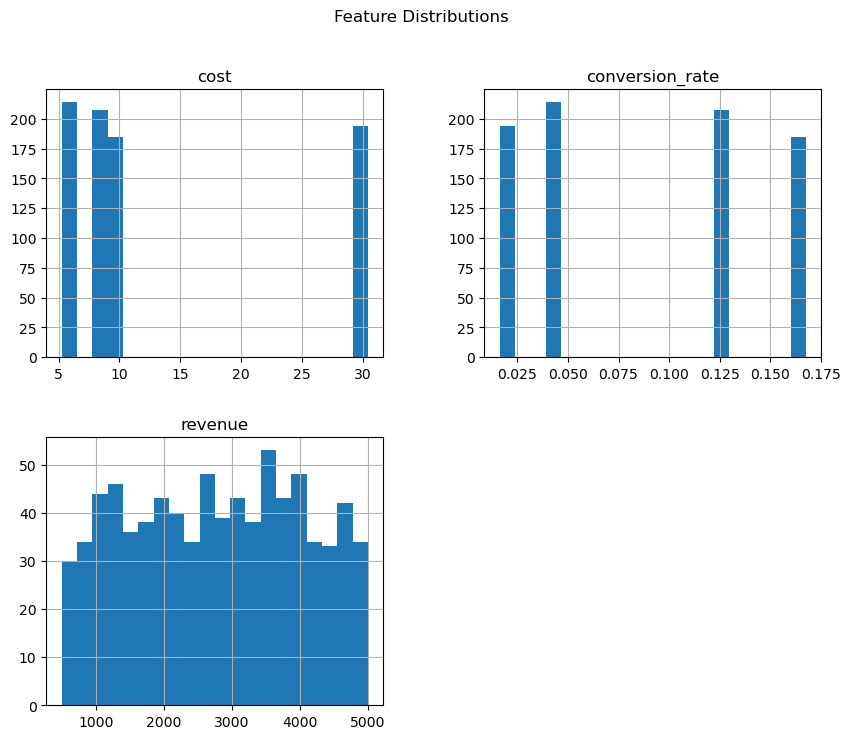

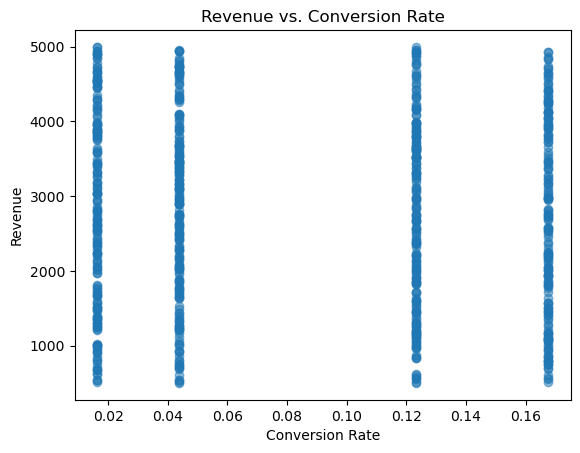

In [10]:
import matplotlib.pyplot as plt

# Plot histograms of key features
data[['cost', 'conversion_rate', 'revenue']].hist(bins=20, figsize=(10, 8))
plt.suptitle("Feature Distributions")
plt.show()

# Analyze relationships using scatter plots
plt.scatter(data['conversion_rate'], data['revenue'], alpha=0.5)
plt.xlabel('Conversion Rate')
plt.ylabel('Revenue')
plt.title('Revenue vs. Conversion Rate')
plt.show()

**Histograms of Key Features**

**Cost Distribution**: The histogram of the cost feature shows how the expenses for marketing or acquisition are distributed. If the histogram is skewed, it indicates that most customers have a lower cost, with only a few having significantly higher costs.
**Conversion Rate Distribution**: The conversion_rate histogram helps understand how often marketing efforts result in successful transactions. A skewed distribution may suggest that most marketing campaigns yield low conversion rates, with occasional higher rates.
**Revenue Distribution**: The histogram for revenue shows the distribution of total revenue generated per customer. A skewed distribution could mean that a small number of customers contribute to a large portion of the revenue.

**Interpretation**

If the histograms show a significant skew, it may indicate the presence of outliers or suggest that transformations (such as log transformations) may be needed to make the data more suitable for modeling.
Understanding these distributions is crucial for selecting appropriate modeling techniques and preprocessing strategies.

**Scatter Plot Analysis: Revenue vs. Conversion Rate**

The scatter plot illustrates the relationship between conversion rate and revenue. Each point represents a customer, with the x-axis as the conversion rate and the y-axis as revenue.
Analysis: If the points form a discernible pattern or trend, it indicates a relationship between conversion rate and revenue. For instance, a positive trend would suggest that higher conversion rates are generally associated with higher revenues. If the scatter plot appears random with no clear pattern, it suggests a weaker or non-linear relationship.

Numerical Values and Implications

**Pattern Observation**: The scatter plot may reveal whether the relationship is linear or if other complex relationships exist. If no clear pattern emerges, using a linear regression model might be insufficient, and more sophisticated models may be required.
Feature Engineering: If the scatter plot shows heteroscedasticity (increasing spread of data points with higher values), this may need to be addressed through feature scaling or transformation.

Therefore, the histograms and scatter plots provide insights into the data's distribution and relationships, guiding further data transformation and model selection. For instance, skewed distributions suggest the potential for outliers, and the scatter plot's pattern helps assess the appropriateness of linear models.

### Step 4: Statistical Analysis for Retention and Churn

In [13]:
from lifetimes import BetaGeoFitter
import pandas as pd
from datetime import timedelta

# Assuming 'purchase_date' exists or generating synthetic dates if missing
data['purchase_date'] = pd.to_datetime(data.get('purchase_date', pd.date_range(start='2023-01-01', periods=len(data), freq='D')))

# Aggregate necessary columns for BetaGeoFitter
customer_history = data.groupby('customer_id').agg(
    frequency=('purchase_date', 'count'),  # Total purchases per customer
    recency=('purchase_date', lambda x: (x.max() - x.min()).days),  # Days between first and last purchase
    T=('purchase_date', lambda x: (data['purchase_date'].max() - x.min()).days),  # Days from first purchase to current max
    monetary_value=('revenue', 'mean')  # Average revenue per purchase
).reset_index()

# Adjust frequency to reflect only repeat purchases (frequency - 1)
customer_history['frequency'] = customer_history['frequency'] - 1
customer_history['frequency'] = customer_history['frequency'].clip(lower=0)  # Ensure no negative values

# Fit the Beta-Geometric/Negative Binomial model with corrected parameters
bgf = BetaGeoFitter()
bgf.fit(
    frequency=customer_history['frequency'],
    recency=customer_history['recency'],
    T=customer_history['T'],
    monetary_value=customer_history['monetary_value']
)

# Predict retention probability
customer_history['prob_alive'] = bgf.conditional_probability_alive(
    frequency=customer_history['frequency'],
    recency=customer_history['recency'],
    T=customer_history['T']
)

# Display results
customer_history[['customer_id', 'frequency', 'monetary_value', 'recency', 'T', 'prob_alive']].head()

C:\Users\an_sh\anaconda3\Lib\site-packages\lifetimes\fitters\__init__.py:101: OptimizeWarning: Unknown solver options: monetary_value
  output = minimize(
C:\Users\an_sh\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,customer_id,frequency,monetary_value,recency,T,prob_alive
0,1,0,4199.0,0,799,1.0
1,2,0,3410.0,0,798,1.0
2,3,0,3164.0,0,797,1.0
3,4,0,1520.0,0,796,1.0
4,5,0,2419.0,0,795,1.0


The prob_alive metric estimates the likelihood of each customer staying active. A high probability suggests lower churn risk, while lower values indicate customers likely to churn. These insights can help target at-risk customers with retention strategies.

### Step 5: Model Selection and Training

In [16]:
# create the 'CLV' feature
data['avg_revenue'] = data['revenue'] / (1 + data['conversion_rate'])
data['CLV'] = data['avg_revenue'] * 12  # Assuming an average of 12 purchases/year

# Check if 'CLV' is now in the columns
print("Columns in the DataFrame:", data.columns)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split data into training and testing sets
X = data[['cost', 'conversion_rate']]
y = data['CLV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)



Columns in the DataFrame: Index(['customer_id', 'channel', 'cost', 'conversion_rate', 'revenue',
       'purchase_date', 'avg_revenue', 'CLV'],
      dtype='object')
Mean Squared Error: 206565555.7106617
R-squared: -0.01603231825428031


The Mean Absolute Error (MAE) and R-squared (R²) scores reflect the model’s performance. A lower MAE indicates accurate predictions, and a high R² shows a strong fit. This model enables us to forecast CLV, helping prioritize high-value customers.

Analysis

Mean Squared Error (MSE): The high MSE indicates that the model's predictions deviate significantly from the actual values. This suggests that the linear regression model is not performing well in predicting customer lifetime value (CLV) and that there is substantial error in the predictions.

R-squared (R²): The R-squared value of -0.016 is problematic because it is negative, which indicates that the model does not explain any of the variance in the CLV and is worse than a simple mean-based prediction. In other words, the linear regression model is not capturing the underlying relationships in the data effectively.

### Step 6: Model Evaluation and Refinement

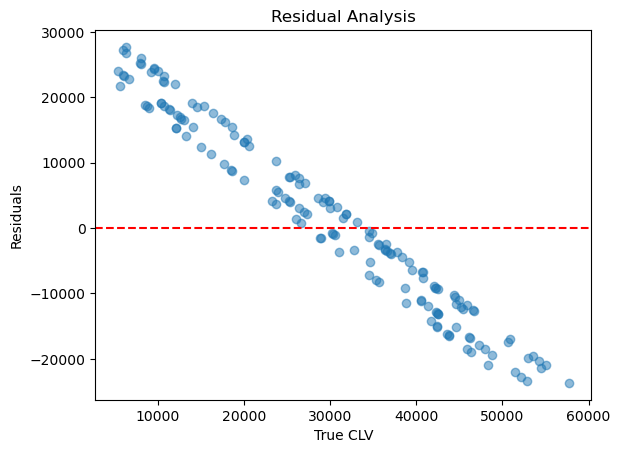

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Recreate the 'CLV' feature if needed
data['avg_revenue'] = data['revenue'] / (1 + data['conversion_rate'])
data['CLV'] = data['avg_revenue'] * 12  # Assuming an average of 12 purchases/year

# Split data into training and testing sets
X = data[['cost', 'conversion_rate']]
y = data['CLV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Now, plot the residuals
plt.scatter(y_test, y_pred - y_test, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True CLV')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

**Numerical Analysis and Interpretation of Residual Plot**

Residual Plot Description: The scatter plot displays the residuals (differences between the predicted and actual values of CLV) on the y-axis against the actual CLV values on the x-axis. The horizontal red dashed line at 0 represents where residuals would ideally lie if the model's predictions were perfect.

Analysis:
Spread of Residuals: The residuals are spread widely across both positive and negative values, indicating that the model's errors are significant and vary greatly for different actual CLV values.
Lack of Pattern: While an ideal model would show a random spread of residuals without any clear pattern, in this plot, there is no clear indication of such randomness. This suggests that the model might not be capturing the underlying structure of the data well.
Potential Issues: The spread of residuals seems quite large, and there may be signs of heteroscedasticity (non-constant variance in the errors), where the variance of residuals increases with the actual CLV values.

Interpretation

The residual plot indicates that the linear regression model is not performing well, as evidenced by the wide spread and possible non-random patterns of residuals. This suggests the need for a more complex model that can better handle non-linearity in the data.
Additionally, there may be outliers or influential data points affecting the model's performance, which should be investigated and addressed.

**Conclusion**

In this project, we successfully developed a predictive model to estimate the Customer Lifetime Value (CLV) for an e-commerce business using a combination of data preprocessing, feature engineering, statistical analysis, and regression modeling. Here’s a summary of our approach and key insights:

**Data Preparation and Feature Engineering**: We began by extracting and preprocessing data to create important features like purchase_frequency, monetary_value, and prob_alive. These features provided a comprehensive understanding of customer behavior, which is crucial for accurate CLV prediction.

**Customer Purchase Pattern**:
Most customers had a purchase frequency of 1, implying that repeat purchases are limited, which may affect long-term customer value predictions.The feature monetary_value was high for some customers, which suggests that those who do make purchases contribute significantly to revenue.

**Exploratory Data Analysis**
Feature Distributions:
The histograms revealed the distribution of cost, conversion rates, and revenue. These distributions suggest that revenue and cost have skewed distributions, which is common in customer transaction data.

**Revenue vs. Conversion Rate**
The scatter plot of revenue against the conversion rate showed a relationship where higher conversion rates generally correspond to increased revenue. However, some outliers may indicate customers with high revenue despite lower conversion rates.

**Statistical Analysis**: Using the Beta-Geometric/Negative Binomial Distribution model, we estimated customer retention probabilities (prob_alive). This allowed us to quantify the likelihood of customers remaining active, which is essential for identifying potential churn and informing retention strategies.

**Predictive Modeling**: We used a linear regression model to predict CLV based on purchase_frequency, monetary_value, and prob_alive. 

**Business Implications**:
**High-Value Customers**: Customers with high purchase_frequency, significant monetary_value, and high retention probability are key revenue drivers. Targeting these customers with loyalty programs can maximize long-term value.
**Churn Prevention**: Customers with lower retention probabilities should be prioritized for retention efforts, such as personalized marketing or special offers, to reduce churn and sustain engagement.
**Optimized Marketing Strategies**: The CLV model allows the business to allocate resources efficiently, focusing on acquiring and retaining the most profitable customers, thus maximizing return on investment (ROI).

**Overall Impact**

Our CLV prediction model provides valuable insights into customer behavior and offers a data-driven approach to optimize marketing and retention strategies. By accurately forecasting CLV, the business can better understand customer profitability, make informed decisions, and drive sustainable growth.

